# Example working with EMIT over Libya-4

EMIT_L1B_RAD_001_20220827T091626_2223906_009

comparable to Fig 23 in Thompson et al. (2023)

In [2]:
import hyperquest

from spectral import *
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA
import numpy as np

In [3]:
# Define path to envi image header file
path_to_data = '../tests/data/EMIT_L1B_RAD_001_20220827T091626_2223906_009.nc'


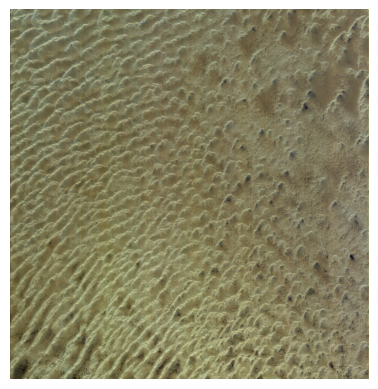

In [4]:
# Load raster
array, fwhm, wave, obs_time = hyperquest.retrieve_data_from_nc(path_to_data)
red = array[:,:,38]
blue = array[:,:,11]
green = array[:,:,24]

red= np.ma.masked_equal(red, -9999)
green = np.ma.masked_equal(green, -9999)
blue = np.ma.masked_equal(blue, -9999)

# Normalize the values for display
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-26.275995515639153..29.37199569631798].


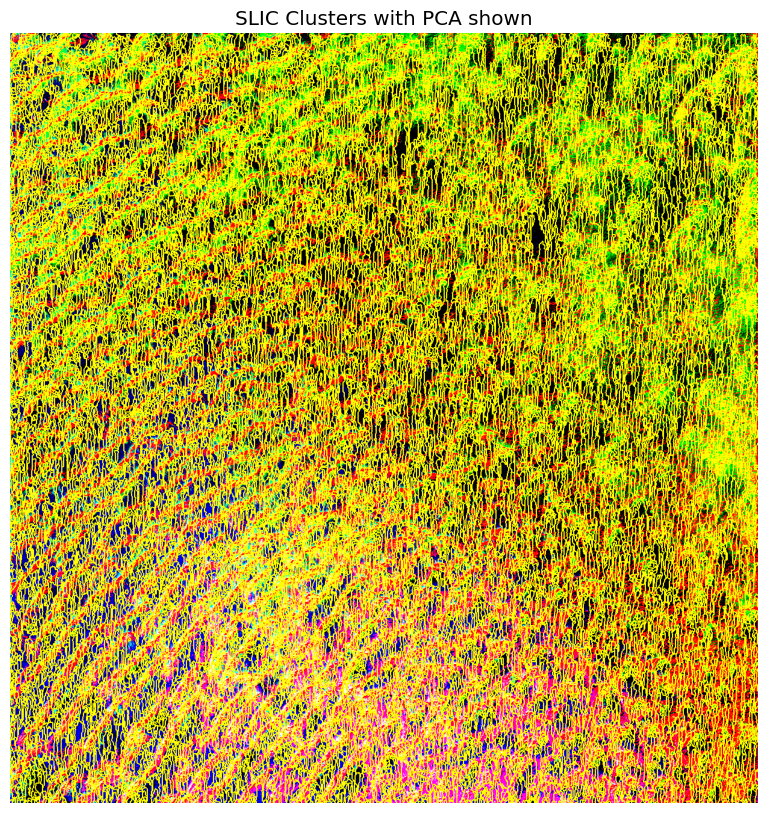

In [10]:
# first 3 components
pca = PCA(n_components=3)
rows, cols, bands = array.shape
array_reshaped = array.reshape(-1, bands)
array_pca = pca.fit_transform(array_reshaped).reshape(rows, cols, -1)

# SLIC
n_segments = 100000
compactness = 0.001


segments = slic(array_pca, 
                n_segments=n_segments, 
                compactness=compactness)


plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(array_pca, segments))
plt.title("SLIC Clusters with PCA shown")
plt.axis("off")
plt.show()

In [11]:
# compute using HRDSDC method
snr_hrdsdc = hyperquest.hrdsdc(path_to_data, 
                               n_segments = n_segments, 
                               compactness = compactness, 
                               n_pca = 3, 
                               ncpus = 8)

In [5]:
# Compare the other methods (varies on block size and number of histogram bins)
snr_ssdc = hyperquest.ssdc(path_to_data,
                           block_size=10,
                           nbins = 150,
                           ncpus = 8)



In [6]:
# (varies on block size and number of histogram bins)
snr_rlsd = hyperquest.rlsd(path_to_data,
                           block_size=10,
                           nbins = 150,
                           ncpus = 8)

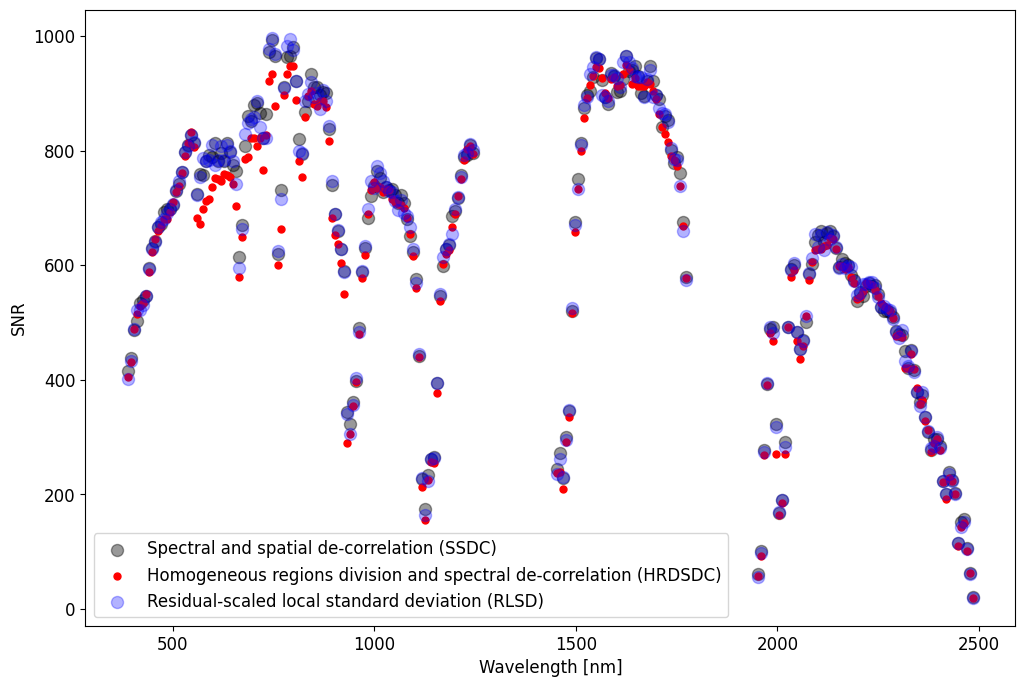

In [12]:
plt.figure(figsize= (12,8))
plt.rcParams.update({'font.size': 12})

plt.scatter(wave, snr_ssdc, color='black', s=75, alpha=0.4)
plt.scatter(wave, snr_hrdsdc, color='red', s=25, alpha=1.0)
plt.scatter(wave, snr_rlsd, color = 'blue', s=75, alpha=0.3)


plt.legend(['Spectral and spatial de-correlation (SSDC)',
             'Homogeneous regions division and spectral de-correlation (HRDSDC)',
             'Residual-scaled local standard deviation (RLSD)'])

plt.xlabel('Wavelength [nm]')
plt.ylabel('SNR')
plt.show()